### Problem 3 - RANSAC
##### When data is scattered, the least squares method to fit a curve might not be the best choice. In this problem, you are given data for health insurance costs based on the person’s age. There are other fields as well, but you have to fit a line only for age and insurance cost data.

###### The data is stored in the file - 'dataset.csv'

>> Read and plot csv file

In [378]:
import csv
import numpy as np
age = []
cost = []
with open('dataset.csv', 'r') as theFile:
    reader = csv.DictReader(theFile)
    for line in reader:
        age.append(float(line['age']))
        cost.append(float(line['charges']))


##### 1. Compute the covariance matrix (from scratch) and find its eigenvalues and eigenvectors. 
###### Plot the eigenvectors on the same graph as the data.

In [379]:
# Calculate mean age and cost
mean_age = sum(age) / len(age)
mean_cost = sum(cost) / len(cost)
var_age = 0.0
var_cost = 0.0
covar_ = 0.0
covar_cost = 0.0
tls_dem = 0.0
for i in range(len(age)):
    var_age += (age[i]-mean_age)**2     # den
    var_cost += (cost[i]-mean_cost)**2
    covar_ += (age[i]-mean_age)*(cost[i]-mean_cost)  # num
    #tls_dem += (((cost)-mean_cost)**2 -(age-mean_age)**2)
var_age /= len(age)
var_cost /= len(age)
covar_ /= len(age)

print('Mean age: ', mean_age, ', Mean cost: ', mean_cost, ', Variance age: ',
      var_age, ', Variance cost: ', var_cost, ', Covariance: ', covar_)


Mean age:  39.19692307692308 , Mean cost:  12417.575373969228 , Variance age:  196.84122130177533 , Variance cost:  122218100.00298595 , Covariance:  52371.79820041833


#### Covariance Matrix:

Covariance Matrix [[1.96841221e+02 5.23717982e+04]
 [5.23717982e+04 1.22218100e+08]]
Eigen Values :
 [1.74399299e+02 1.22218122e+08] 
Eigen Vector :
 [[-9.99999908e-01 -4.28511555e-04]
 [ 4.28511555e-04 -9.99999908e-01]]
[[-9.99999908e-01]
 [ 4.28511555e-04]]
[[-4.28511555e-04]
 [-9.99999908e-01]]


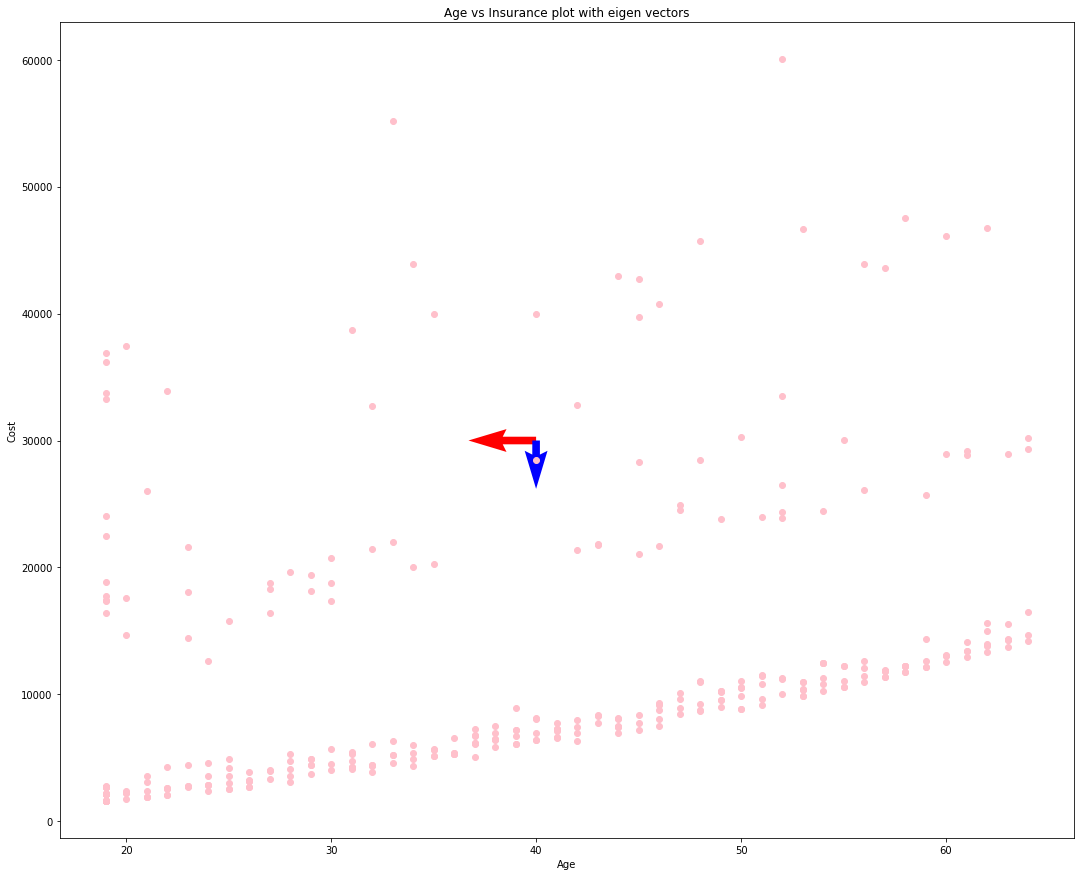

In [380]:
import matplotlib.pyplot as plot
from numpy import linalg as LA
import math
import random

covariance_mat = np.matrix([[var_age, covar_], [covar_, var_cost]])
print('Covariance Matrix', covariance_mat)
eigen_values, eigen_vector = LA.eig(covariance_mat)
print('Eigen Values :\n', eigen_values, '\nEigen Vector :\n', eigen_vector)

# find out covariance with respect  columns
cov_mat = np.stack((age, cost), axis=0)


fig1 = plot.figure(figsize=(40, 15))
plot.subplot(121)


# Plotting Eigen vectors
origin = [40, 30000]

eig_vec1 = np.array(eigen_vector[:, 0])
eig_vec2 = np.array(eigen_vector[:, 1])


print(eig_vec1)
print(eig_vec2)

plot.quiver(*origin, *eig_vec1, color=['r'], scale=15)
plot.quiver(*origin, *eig_vec2, color=['b'], scale=21)

plot.xlabel('Age')
plot.ylabel('Cost')
plot.scatter(age, cost, c="pink")
plot.title('Age vs Insurance plot with eigen vectors')


#### 2.1 Fit a line to the data using linear least square method

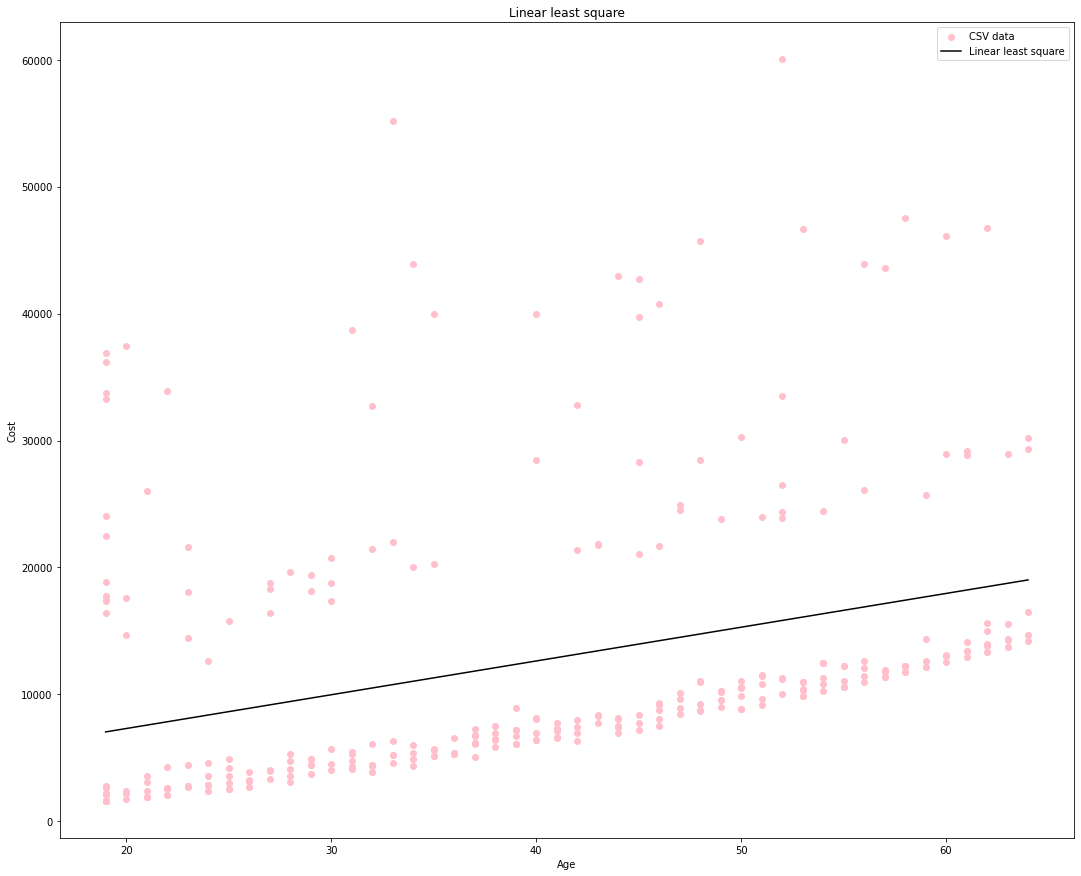

In [381]:
m = covar_/var_age
c = mean_cost - m*mean_age

Y_pred = m*np.array(age) + c

fig1 = plot.figure(figsize=(40, 15))
plot.subplot(121)
plot.xlabel('Age')
plot.ylabel('Cost')
plot.scatter(age, cost, c="pink", label="CSV data")
plot.plot([min(age), max(age)], [min(Y_pred), max(Y_pred)],
          color='black', label='Linear least square')  # predicted
plot.legend()
plot.title('Dataset')

# Uncomment and run to validate
# A = np.vstack([np.array(age), np.ones(len(age))]).T
# m, c = np.linalg.lstsq(A, cost, rcond=None)[0]
# q = plot.plot(np.array(age), m*np.array(age) + c, 'r', label='Fitted line')


plot.title('Linear least square')
plot.savefig('LLS.png')


In [382]:
# SVD function 

def SVD(A):     # returns VT,U,S = result of SVD
    A_At = A.transpose()
    # print(A_At)

    # Calculate A dot A transpose and A transpose dot A
    At_A = np.dot(A_At, A)
    #print("A_transpose.A = \n",At_A)
    A_At = np.dot(A,A_At)
    #print("A.A_transpose = \n",A_At)

    # GEt EIgen value and eigen vectors of A transpose dot A
    V_eigen_val, V_eigen_vec = LA.eig(At_A)
    # GEt EIgen value and eigen vectors of A dot A transpose
    U_eigen_val, U_eigen_vec = LA.eig(A_At)

    # Arrange eigen values and vectors in descending order for V
    V_eigen_val_ = V_eigen_val.argsort()[::-1]
    V_eigen_vec_ = V_eigen_vec[:, V_eigen_val_]
    V_eigen_vec_transpose = V_eigen_vec_.T



    # Arrange eigen values and vectors in descending order for U
    U_eigen_val_ = U_eigen_val.argsort()[::-1]
    U_eigen_vec_ = U_eigen_val[U_eigen_val_]
    U_eigen_vec__ = U_eigen_vec[:, U_eigen_val_]


    # Arrange elements for sigma
    U_diagonal_sqrt = np.diag((np.sqrt(U_eigen_vec_)))
    S = np.zeros_like(A).astype(np.float64)
    S[:U_diagonal_sqrt.shape[0], :U_diagonal_sqrt.shape[1]] = U_diagonal_sqrt

    return V_eigen_vec_transpose, U_eigen_vec__, S


#### Line fitting using total least square (aka orthogonal linear regression)

In [383]:
def tls(x,y):
    x = (x-np.min(x))/(np.max(x)-np.min(x))
    y = (y-np.min(y))/(np.max(y)-np.min(y))
    mean_age_new = sum(x)/len(x)
    mean_cost_new = sum(y)/len(y)

    #Define Matrix A
    A = np.vstack(((x-mean_age_new),(y-mean_cost_new))).T
    At_A = np.dot(A.T,A)
    V,U,S = SVD(At_A)
    a,b = V[:,-1]
    c = a*mean_age_new + b*mean_cost_new
    print(a,b,c)
    return a,b,c


0.2840280876990921 0.9588159601289483 0.30473092267741514
325


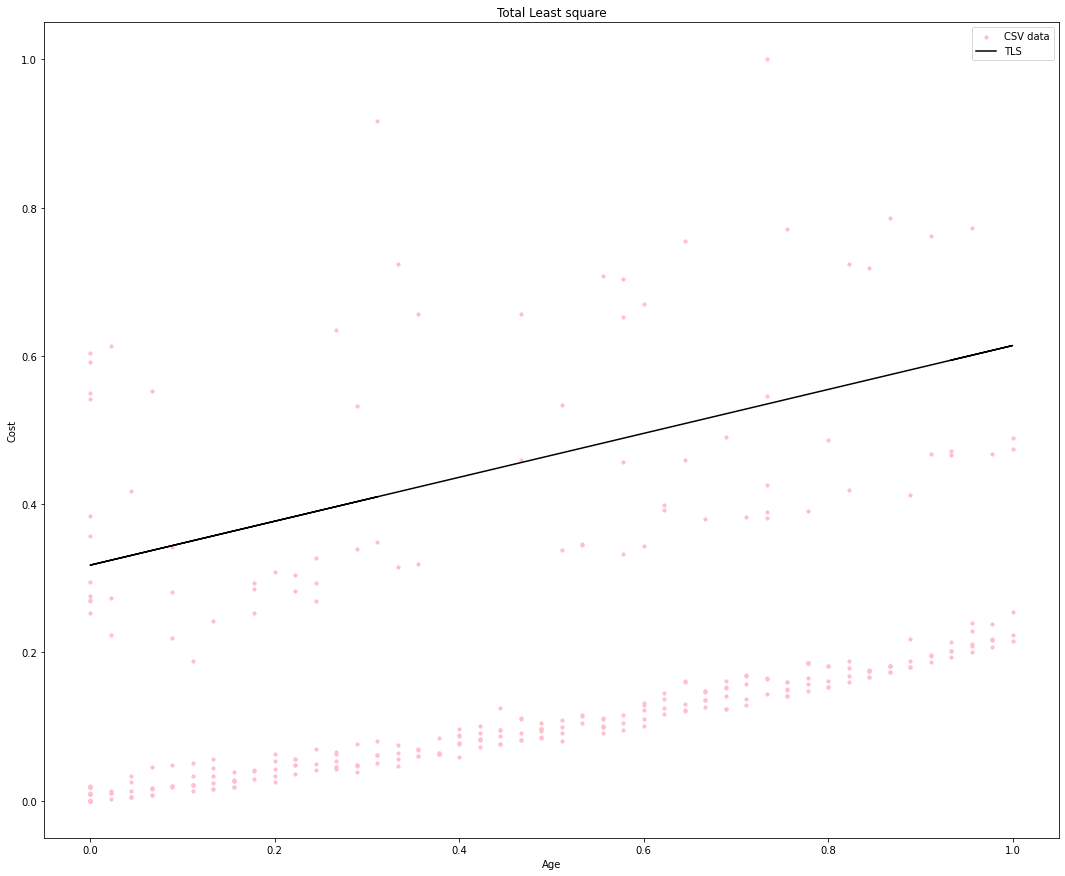

In [384]:
import random
from scipy.odr import *


def tls(X, y):
    if len(X.shape) == 1:
        n = 1
        X = X.reshape(len(X), 1)
    else:
        n = np.array(X).shape[1]  # the number of variable of X

    Z = np.vstack((X.T, y)).T
    U, s, Vt = LA.svd(Z, full_matrices=True)

    V = Vt.T
    Vxy = V[:n, n:]
    Vyy = V[n:, n:]
    a_tls = - Vxy / Vyy  # total least squares soln

    Xtyt = - Z.dot(V[:, n:]).dot(V[:, n:].T)
    Xt = Xtyt[:, :n]  # X error
    y_tls = (X+Xt).dot(a_tls)

    fro_norm = LA.norm(Xtyt, 'fro')  # Frobenius norm

    return y_tls, X + Xt, a_tls, fro_norm


Y_, X_, a_, norm = tls(np.array(age), np.array(cost))


# Define a function (quadratic in our case) to fit the data with.
def linear_func(p, x):
    m, c = p
    return m*x + c


# Create a model for fitting.
linear_model = Model(linear_func)

# Create a RealData object using our initiated data from above.
data = RealData(age, cost)

# Set up ODR with the model and data.
odr = ODR(data, linear_model, beta0=[0., 1.])

# Run the regression.
out = odr.run()
Y_inbuild = out.beta[0]*np.array(age) + out.beta[1]

fig1 = plot.figure(figsize=(40, 15))
plot.subplot(121)
plot.xlabel('Age')
plot.ylabel('Cost')
plot.scatter(age, cost, c="pink", label="CSV data")
plot.scatter(X_, Y_, c="black", label="TLS")
plot.scatter(age, Y_inbuild, c="blue", label="TLS_I")
plot.legend()
plot.title('Dataset')


In [385]:
def get_coef(age, cost):
    age = np.array(age)
    cost = np.array(cost)
    mean_x = np.mean(age)
    mean_y = np.mean(cost)
    SS_xx = np.sum(age*age) - len(age)*mean_x*mean_x
    SS_xy = np.sum(cost*age) - len(age)*mean_y*mean_x
    b = SS_xy / SS_xx
    a = mean_y - b*mean_x 
    return (a, b)

## RANSAC

In [386]:
import random

def RANSAC(points, outliers, iterations,threshold,precision):
    coefficients = []
    samples = len(points)
    best_coef = np.zeros([3, 1])
    chosen_points = np.zeros([3, 2])
    e = outliers / samples
    s = 2  # 2 points required to fit a line
    for i in range(iterations):
        sample_points = random.sample(points, 2)
        #print("Sample points", sample_points)
        list_x, list_y = zip(*sample_points)
        a,b = get_coef(list_x, list_y)
        #print("tls:",s)
        inlierscount = 0
        maximum_inlierscount = 0
        for i in range(0, samples):
            distance = abs((a*age[i]) + b - cost[i])/(np.sqrt(a*a + b*b))
            if distance <= threshold:
                inlierscount += 1
            if inlierscount > maximum_inlierscount:
                coefficients = [a, b]
                maximum_inlierscount - inlierscount

    return coefficients


/tmp/ipykernel_9836/124317513.py:8: RuntimeWarning: invalid value encountered in double_scalars
  b = SS_xy / SS_xx
/tmp/ipykernel_9836/124317513.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  b = SS_xy / SS_xx
/tmp/ipykernel_9836/1960474324.py:19: RuntimeWarning: invalid value encountered in double_scalars
  distance = abs((a*age[i]) + b - cost[i])/(np.sqrt(a*a + b*b))


coef [452.7068333334828, 197.91368333333068]


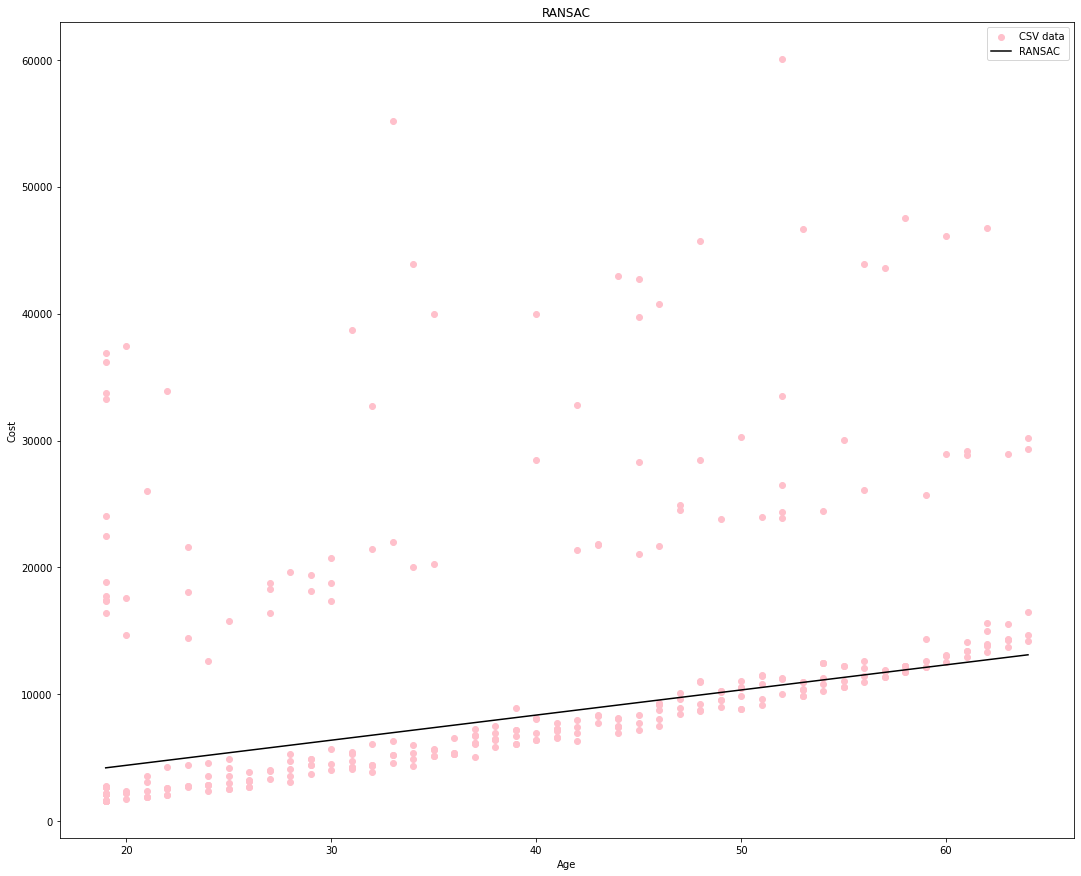

In [387]:
coef = RANSAC(list(zip(age,cost)),6,len(age),10,0.999999)
print("coef",coef)


Y_pred = coef[1]*np.array(age) + coef[0]

fig1 = plot.figure(figsize=(40, 15))
plot.subplot(121)
plot.xlabel('Age')
plot.ylabel('Cost')
plot.scatter(age, cost, c="pink", label="CSV data")
plot.plot([min(age), max(age)], [min(Y_pred), max(Y_pred)],
          color='black', label='RANSAC')  # predicted
plot.legend()
plot.title('RANSAC line fitting')

plot.title('RANSAC')
plot.savefig('RANSAC.png')